# Classifiez automatiquement des biens de consommation - partie textuelle - modélisation non supervisée

## 1. Introduction

__Contexte__

Place de marché® est un e-commerce qui met direction en relation les vendeurs et les acheteurs. A ce jour, les vendeurs doivent insérer une photo, une description du produit qu'ils vendent et aussi le trier dans sa catégorie. Cependant, il arrive que ces derniers se trompent dans lorsqu'ils le catégorisent. 

__Problématiques__

C'est pourquoi Place de marché souhaite automatiser la catégorisation des produits à partir de son image et/ou de sa description avec l'aide d'un moteur de classifiation automatique.

__Droits d'utilisation des données Flipkart__

Le dossier Flipkart a été échantillonné à partir des données mises sur Kaggle, avec l'autorisation de Flipkart: comme il est visible dans cette image ci-dessous où nous voyons qu'ils sont sous la licence [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) qui stipule qu'il est possible d'utiliser, de modifier et de partager ces données. Nous pouvons donc continuer le reste de l'étude de faisabilité sans nous soucier d'enfreindre la loi de ce côté-là. 

Cependant cela n'inclut que le dataframe. Malheureusement, j'ai beau cherché, rien n'indique que les images peuvent être utilisées: voire même Flipkart stipule dans sa page "https://affiliate.flipkart.com/terms-of-use" dans la section "Trademark, Copyright and Restriction" que nous ne pouvons pas l'utiliser sans leur autorisation. Cependant, comme ce dataset est utilisé par OpenClassrooms, j'en ai conclu qu'il était possible que je travaille sur ce dernier. 

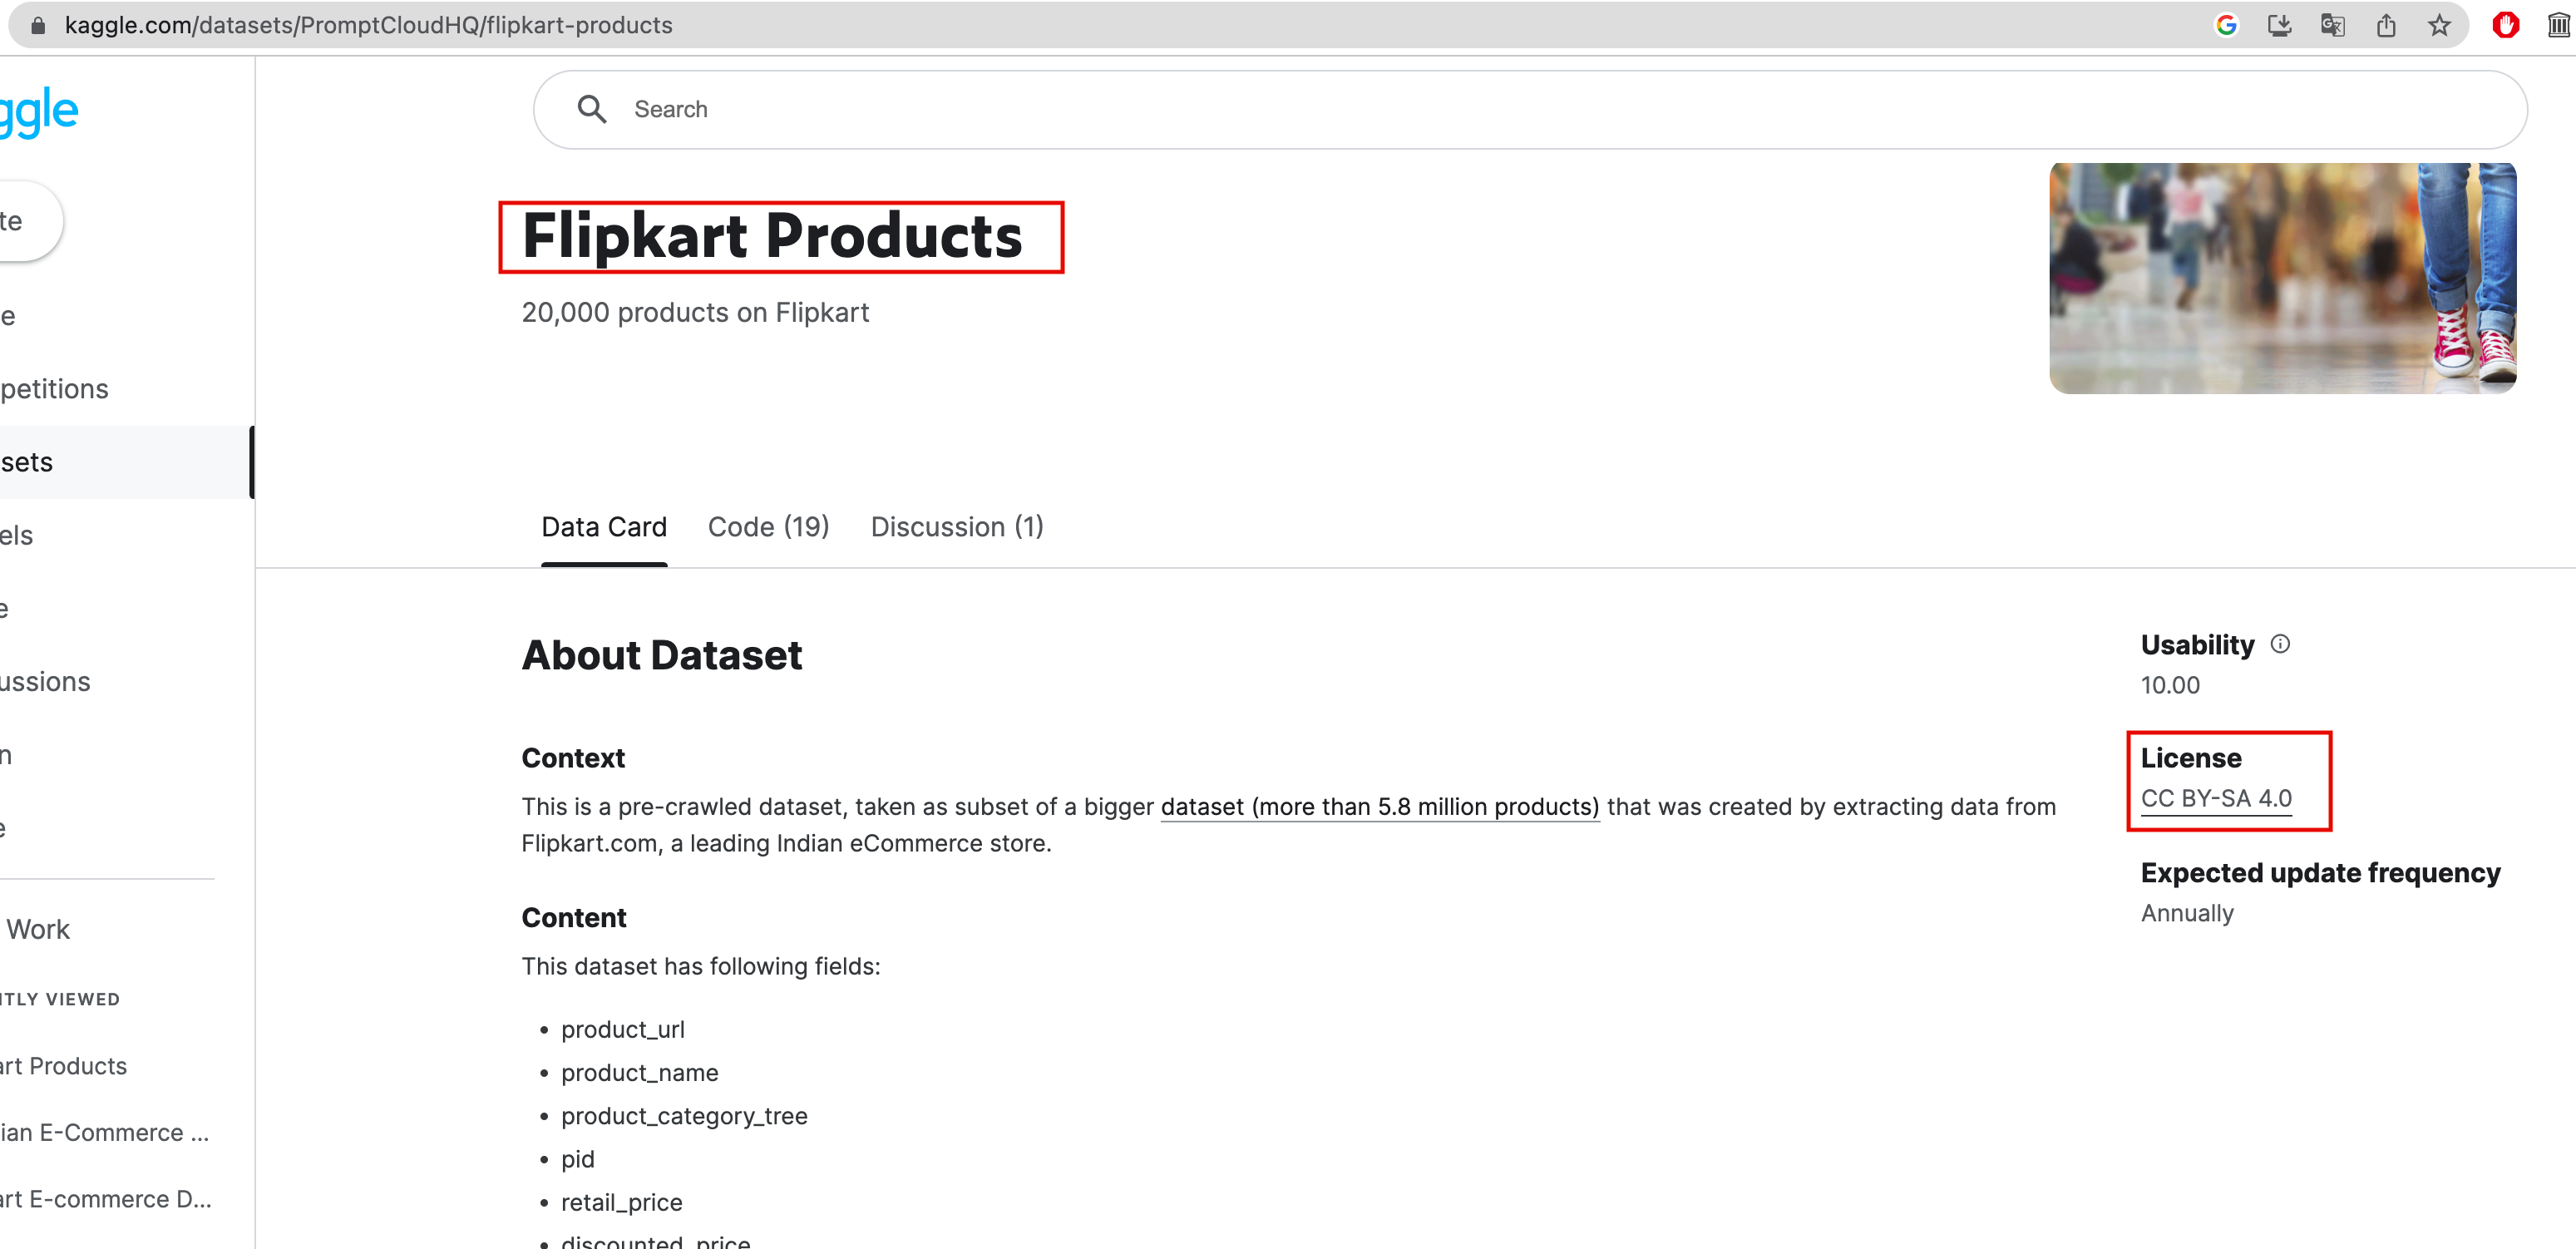

### Les critères à remplir dans ce notebook
   1. __Prétraiter des données textes pour obtenir un jeu de données exploitable.__
      - CE1 Vous avez nettoyé les champs de texte (suppression de la ponctuation et des mots de liaison, mise en minuscules)
      - CE2 Vous avez écrit une fonction permettant de “tokeniser” une phrase.
      - CE3 Vous avez écrit une fonction permettant de “stemmer” une phrase.
      - CE4 Vous avez écrit une fonction permettant de “lemmatiser” une phrase.
      - CE5 Vous avez construit des features ("feature engineering") de type bag-of-words (bag-of-words standard : comptage de mots, et Tf-idf), avec des étapes de nettoyage supplémentaires : seuil de fréquence des mots, normalisation des mots.
      - CE6 Vous avez testé une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.
      - CE7 Vous avez, en complément de la démarche de type “bag-of-words”, mis en oeuvre 3 démarches de word/sentence embedding : Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder).
      - CE8 Vous vous êtes assurés que le texte traité ne relève pas d’une propriété intellectuelle dont l’utilisation ou la modification est interdite.

   2. __Mettre en œuvre des techniques de réduction de dimension.__
      - CE1 Vous avez justifié la nécessité de la réduction de dimension. 
      - CE2 Vous avez appliqué une méthode de réduction de dimension adaptée à la problématique (ex. : ACP). 
      - CE3 Vous avez justifié le choix des valeurs des paramètres dans la méthode de réduction de dimension retenue (ex. : le nombre de dimensions conservées pour l'ACP).  
 
   3. __Représenter graphiquement des données à grandes dimensions.__
      - CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique).
      - CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).
      - CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

### Les critères à remplir dans ce notebook
   1. __Prétraiter des données textes pour obtenir un jeu de données exploitable.__
      - CE1 Vous avez nettoyé les champs de texte (suppression de la ponctuation et des mots de liaison, mise en minuscules)
      - CE2 Vous avez écrit une fonction permettant de “tokeniser” une phrase.
      - CE3 Vous avez écrit une fonction permettant de “stemmer” une phrase.
      - CE4 Vous avez écrit une fonction permettant de “lemmatiser” une phrase.
      - CE5 Vous avez construit des features ("feature engineering") de type bag-of-words (bag-of-words standard : comptage de mots, et Tf-idf), avec des étapes de nettoyage supplémentaires : seuil de fréquence des mots, normalisation des mots.
      - CE6 Vous avez testé une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.
      - CE7 Vous avez, en complément de la démarche de type “bag-of-words”, mis en oeuvre 3 démarches de word/sentence embedding : Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder).
      - CE8 Vous vous êtes assurés que le texte traité ne relève pas d’une propriété intellectuelle dont l’utilisation ou la modification est interdite.

   2. __Mettre en œuvre des techniques de réduction de dimension.__
      - CE1 Vous avez justifié la nécessité de la réduction de dimension. 
      - CE2 Vous avez appliqué une méthode de réduction de dimension adaptée à la problématique (ex. : ACP). 
      - CE3 Vous avez justifié le choix des valeurs des paramètres dans la méthode de réduction de dimension retenue (ex. : le nombre de dimensions conservées pour l'ACP).  
 
   3. __Représenter graphiquement des données à grandes dimensions.__
      - CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique).
      - CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).
      - CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

## Préparation de l'environnement

__Importation des librairies et du jeu de données__

In [ ]:
# Installation des librairies utiles pour la partie textuelle
#!pip3 install --quiet "tensorflow-text==2.8.*" # Mettre le bon chiffre final
#!pip3 install --quiet "tensorflow-text
#!pip install umap-learn
#!pip install tensorflow==2.8.4
#!pip install nltk
#!pip install enchant #pour les fautes d'orthographe

In [ ]:
# Importation de librairies de base
from google.colab import drive
import sys
import logging
import os
from os import listdir
os.environ["TF_KERAS"]='1'

import pandas as pd
import numpy as np
import time
from IPython.display import display

# Librairie pour la visualisation 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import ListedColormap, BoundaryNorm
import plotly.express as px

# Nettoyage textuelle
import string
import re
import unicodedata
import random
from scipy.stats import randint as sp_randint
#import enchant

# Tokenisation, Stemmatisation et Lemmatisation 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, GlobalAveragePooling1D, Dropout, Embedding, Dense
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
import multiprocessing
#import torch
import transformers
from transformers import AutoTokenizer, TFAutoModel

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
# librairies pour l'extraction des features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize, FunctionTransformer, LabelEncoder

# librairies pour la réduction des dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, PCA

# librairies pour le clustering
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture

# librairie pour l'évaluation du modèle 
from sklearn.metrics import (homogeneity_score, v_measure_score, completeness_score, 
                             confusion_matrix, precision_score, recall_score, 
                             accuracy_score, adjusted_rand_score, classification_report)
from joblib import dump, load

In [ ]:
# Initialisation du random seed à 42
np.random.seed(42)
from sklearn.utils import check_random_state
random_state = check_random_state(42)
random_seed = 42